In [1]:
from graph import *
from models import *

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import plotly.graph_objects as go

In [4]:
scaling = pd.read_excel("wall time scaling.xlsx", sheet_name="Data")

In [5]:
fit_poly = lambda x, k3, k2, k1: k3 * x ** 3 + k2 * x ** 2 + k1 * x
k, cv = curve_fit(fit_poly, scaling["Size"], scaling["Wall Time"])
k_gpu, cv_gpu = curve_fit(fit_poly, scaling["Size"], scaling["Wall Time GPU"])

In [6]:
funcs = {"Global": lambda x: fit_poly(x, *k), "Intermediate": lambda x: x / 2.0e6}
funcs_gpu = {"Global": lambda x: fit_poly(x, *k_gpu), "Intermediate": lambda x: x / 2.0e6}

In [7]:
detectors, triggers, globals = dataframes_from_spreadsheet("cms_system_200.xlsx")

In [8]:
triggers.iloc[4]["Reduction"]

53.3

In [9]:
cms_run5  = construct_graph(detectors, triggers, globals, funcs)

In [10]:
cms_run5

In [11]:
cms_run5.nodes["Intermediate"]["classifier"].ratio

52.3

In [12]:
cms_run5.nodes["Intermediate"]["classifier"].error_matrix

array([[0.98138869, 0.17965359],
       [0.01861131, 0.82034641]])

In [13]:
cms_run5.nodes["Intermediate"]["contingency"]

array([[3.92481827e+07, 1.34824461e+03],
       [7.44312611e+05, 6.15644582e+03]])

In [14]:
cms_run5.graph["op power"] / 1e6 / density_scale_model(2032)

51.57977399881208

In [15]:
total_reduction = 40e6 / 7.5e3

In [16]:
triggers

,Name,Output,Data (bytes),Reduction,Skill mean,Skill variance,Link Efficiency (J/bit),Op Efficiency (J/op),Compression
0,Tracking,Intermediate,0,1.0,0,0,2.500000e-11,0.000,0
1,Timing,Intermediate,0,1.0,0,0,2.500000e-11,0.000,0
2,Calorimetry,Intermediate,0,1.0,0,0,2.500000e-11,0.000,0
3,Muon,Intermediate,0,1.0,0,0,2.500000e-11,0.000,0
4,Intermediate,Global,260000,53.3,3,1,2.500000e-11,0.003,0
5,Global,Disk,0,100.0,4,1,2.500000e-11,16.000,0
6,Disk,NaN,0,1.0,0,0,2.500000e-11,0.000,0


In [17]:
total_reduction

5333.333333333333

In [18]:
5333 / 20

266.65

In [19]:
from metrics import *

In [20]:
def vary_l1t_accept(reduction: float):
    t = triggers.copy()
    #intermediate reduction stage
    t.at[4, "Reduction"] = reduction
    #global reduction stage
    t.at[5, "Reduction"] = total_reduction / reduction
    g = construct_graph(detectors, t, globals, funcs)

    power = g.graph["op power"] + g.graph["link power"]
    p = g.graph["performance"]
    a = precision(p)
    r = recall(p)
    f1 = f1_score(p)
    #return g

    return (power, a, r, f1), p

In [21]:
g3 = vary_l1t_accept(53.3)

In [22]:
#vary_l1t_accept(53.3).graph["performance"]

In [23]:
#vary_l1t_accept(10).graph["performance"]

In [24]:
#vary_l1t_accept(1).graph["performance"]

In [41]:
l1t_reductions = np.linspace(100, 10, 91)

In [42]:
l1t_reductions

array([100.,  99.,  98.,  97.,  96.,  95.,  94.,  93.,  92.,  91.,  90.,
        89.,  88.,  87.,  86.,  85.,  84.,  83.,  82.,  81.,  80.,  79.,
        78.,  77.,  76.,  75.,  74.,  73.,  72.,  71.,  70.,  69.,  68.,
        67.,  66.,  65.,  64.,  63.,  62.,  61.,  60.,  59.,  58.,  57.,
        56.,  55.,  54.,  53.,  52.,  51.,  50.,  49.,  48.,  47.,  46.,
        45.,  44.,  43.,  42.,  41.,  40.,  39.,  38.,  37.,  36.,  35.,
        34.,  33.,  32.,  31.,  30.,  29.,  28.,  27.,  26.,  25.,  24.,
        23.,  22.,  21.,  20.,  19.,  18.,  17.,  16.,  15.,  14.,  13.,
        12.,  11.,  10.])

In [43]:
res = [vary_l1t_accept(r) for r in l1t_reductions]

In [44]:
c = np.stack([r[1] for r in res])

In [45]:
c[0]

array([[3.99902173e+07, 2.28267595e+03],
       [2.28267599e+03, 5.21732405e+03]])

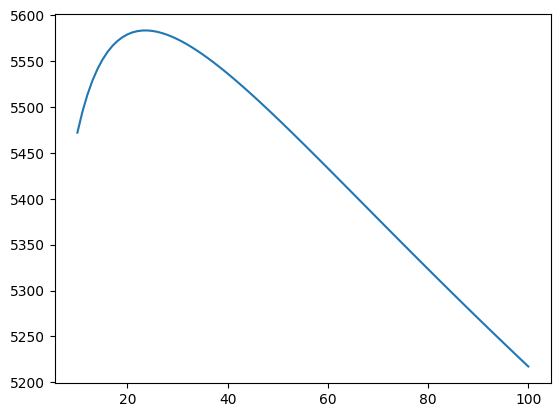

In [46]:
plt.plot(l1t_reductions, [x[1,1] for x in c], label="TP")

In [51]:
l1t_reductions[np.argmax([x[0,0] for x in c])]

24.0

In [52]:
5333.3 / 24.0

222.22083333333333

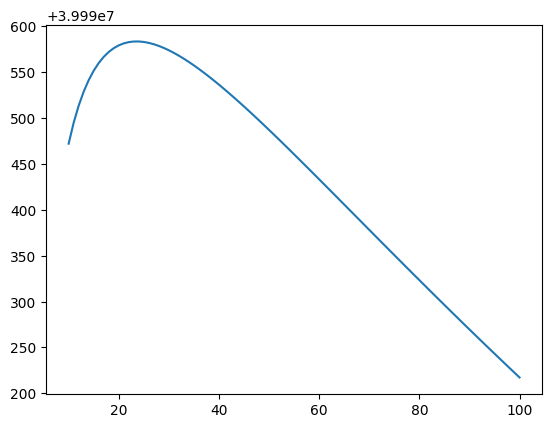

In [48]:
plt.plot(l1t_reductions, [x[0,0] for x in c], label="TN")

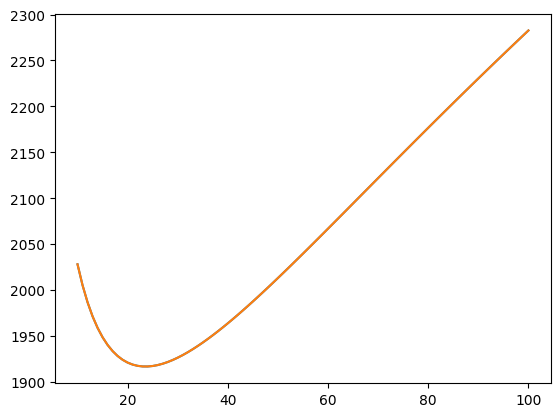

In [49]:
plt.plot(l1t_reductions, [x[1,0] for x in c], label="FP")
plt.plot(l1t_reductions, [x[0,1] for x in c], label="FN")

In [31]:
np.sum(c, axis=(1,2))

array([40000000.        , 40000000.        , 40000000.        ,
       40000000.        , 40000000.        , 40000000.00000001,
       40000000.        , 40000000.        , 40000000.        ,
       40000000.        , 40000000.        , 39999999.99999999,
       39999999.99999999, 39999999.99999999, 40000000.        ,
       40000000.        , 40000000.        , 40000000.        ,
       40000000.        , 40000000.        , 40000000.        ,
       40000000.00000001, 39999999.99999999, 40000000.        ,
       40000000.00000001, 39999999.99999999, 39999999.99999999,
       40000000.        , 40000000.        , 40000000.00000001,
       40000000.        , 39999999.99999999, 40000000.        ,
       40000000.        , 40000000.        , 40000000.        ,
       40000000.        , 40000000.        , 40000000.        ,
       40000000.        , 40000000.00000001, 40000000.        ,
       40000000.        , 40000000.        , 39999999.99999999,
       40000000.00000001, 40000000.     

In [39]:
[np.sum(x[1,:]) for x in c]

[7500.000034093784,
 7500.000124350654,
 7500.000356816555,
 7500.000203139365,
 7499.999376330074,
 7500.0001753445795,
 7500.00054418541,
 7499.999618057664,
 7500.000245498073,
 7500.000013290955,
 7499.999804991958,
 7500.000228662006,
 7500.000017370405,
 7499.999927768153,
 7499.999861564637,
 7499.999846117815,
 7500.0001175092075,
 7499.999644261832,
 7500.000019901974,
 7499.999570969179,
 7499.999694602608,
 7499.999885761503,
 7499.999933582583,
 7500.000211221258,
 7500.000345191171,
 7499.999567261888,
 7500.000077481936,
 7500.000239137491,
 7499.9998289037285,
 7499.99997713093,
 7500.000169985724,
 7500.000305727848,
 7499.999930299044,
 7500.000119038641,
 7499.999681840613,
 7499.999749610011,
 7499.99992733474,
 7499.99982062863,
 7499.999865411608,
 7500.0001690668305,
 7500.000296259275,
 7499.999761273975,
 7499.9997051455975,
 7499.9997539225005,
 7500.000207913674,
 7500.000234975382,
 7500.000072795983,
 7500.000118664183,
 7499.999921494375,
 7499.999706371365

In [32]:
c.shape

(91, 2, 2)

In [33]:
c[0]

array([[3.99902173e+07, 2.28267595e+03],
       [2.28267599e+03, 5.21732405e+03]])

In [34]:
c[50]

array([[3.99904871e+07, 2.01292039e+03],
       [2.01292029e+03, 5.48707961e+03]])

In [35]:
res2 = np.stack([r[0] for r in res])

In [36]:
res2.shape

(91, 4)

In [37]:
res2[:,1]

array([0.6956432 , 0.69633152, 0.69702196, 0.69771454, 0.69840928,
       0.69910599, 0.69980478, 0.70050571, 0.70120854, 0.70191342,
       0.70262025, 0.70332896, 0.7040396 , 0.70475208, 0.70546637,
       0.70618243, 0.70690019, 0.70761967, 0.70834071, 0.70906336,
       0.70978747, 0.71051301, 0.71123992, 0.71196809, 0.71269747,
       0.71342804, 0.71415953, 0.71489197, 0.71562526, 0.71635921,
       0.71709373, 0.7178287 , 0.71856401, 0.71929943, 0.72003488,
       0.72077011, 0.72150497, 0.72223928, 0.72297279, 0.72370527,
       0.72443652, 0.72516628, 0.72589421, 0.72662002, 0.72734337,
       0.72806395, 0.72878138, 0.72949521, 0.73020503, 0.73091035,
       0.73161062, 0.73230534, 0.73299387, 0.73367554, 0.73434968,
       0.73501548, 0.73567211, 0.73631869, 0.73695416, 0.73757743,
       0.73818731, 0.73878251, 0.73936161, 0.73992293, 0.74046482,
       0.74098527, 0.74148219, 0.74195314, 0.74239557, 0.74280641,
       0.74318243, 0.7435199 , 0.74381458, 0.74406183, 0.74425

Text(0.5, 0, 'DAQ Power')

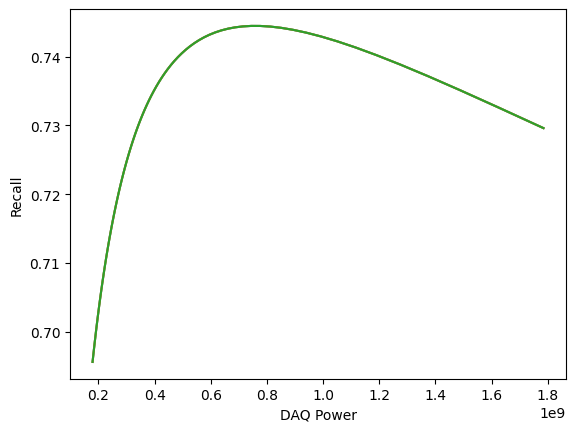

In [38]:
plt.plot(res2[:,0], res2[:,1], label = "Precision")
plt.plot(res2[:,0], res2[:,2], label = "Recall")
plt.plot(res2[:,0], res2[:,3], label = "F1")
plt.ylabel("Recall")
plt.xlabel("DAQ Power")